# 0 Spark Session

Before working with Spark, we need an entry point. The so called *Spark Session* allows us to create DataFrames etc.

In [1]:
from pyspark.sql import SparkSession

if not 'spark' in locals():
    spark = SparkSession.builder \
        .master("local[*]") \
        .config("spark.driver.memory","4G") \
        .getOrCreate()

spark

/opt/anaconda3/lib/python3.10/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/08 17:56:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# PySpark Introduction

This introdactionary Jupyter notebook is  intended to provide a self-learning basis for getting started with Apache Spark with Python. It contains all basic operations (transofmrations, filtering, joins, grouping and aggregation) and serves as a small reference for later training exercises.

## Organisation

The Notebook contains multiple sections, each with a small introduction on the specific topic, some PySpark example code and some small exercises, where you can directly apply the newly learned material.

## Prerequisites
You need a Jupyter Notebook environment with an embedded Spark context. You might need to ask your administrator to setup an appropiate environment. Moreover some small test data is also required to be at a location accessible from Spark.

In [8]:
# Set the base directory according to your environment
basedir = "s3://dimajix-training/data/"

# 1. Reading Data

For working with data, we need to get some data first. Spark supports various file formats, we will use CSV in the following example.

The entrypoint for creating Spark objects is an object called `spark` which is provided in the notebook and read to use. We will read a file containing some informations on a couple of persons, which will serve as the basis for the next examples.

In [14]:
persons = spark.read \
    .option("inferSchema", True) \
    .option("header", True) \
    .csv(basedir + "persons_header.csv")

## Inspecting Data

The read operation returns a so called Spark *DataFrame* object. This object is similar to a table, it contains rows of records, which all conform to a common schema with named columns and specific types. On the surface it heavily borrows concepts from Pandas DataFrames or R DataFrames, although the syntax and many operations are syntactically very different.

As the first step, we want to see the contents of the DataFrame. This can be easily done by using the `show` method.

In [15]:
persons.show()

+---+------+-------+------+
|age|height|   name|   sex|
+---+------+-------+------+
| 23|   156|  Alice|female|
| 21|   181|    Bob|  male|
| 27|   176|Charlie|  male|
| 24|   167|    Eve|female|
| 19|   172|Frances|female|
| 31|   191| George|female|
+---+------+-------+------+



### Inspecting the Schema
It may also be interesting not to inspect the data directly, but to inspect the schema. The schema contains the meta information about which columns are present and which types are used in the columns. You can either directly work with the schema object by using the `schema` variable of a DataFrame, or you can print the schema with the `printSchema()` method as follows:

In [16]:
persons.printSchema()

root
 |-- age: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)



### Converting to Pandas
Spark also provides some convenience method for converting a Spark DataFrame into a Pandas DataFrame. This is not only useful for using Pandas algorithms, but this is particular handy in Jupyter notebooks which have built-in support for displaying Pandas DataFrames nicely. Therefore we will prefer to use the `toPandas()` method for displaying the contents of a DataFrame instead of the `show()` method above.

In [17]:
persons.toPandas()

,age,height,name,sex
0,23,156,Alice,female
1,21,181,Bob,male
2,27,176,Charlie,male
3,24,167,Eve,female
4,19,172,Frances,female
5,31,191,George,female


<Axes: >

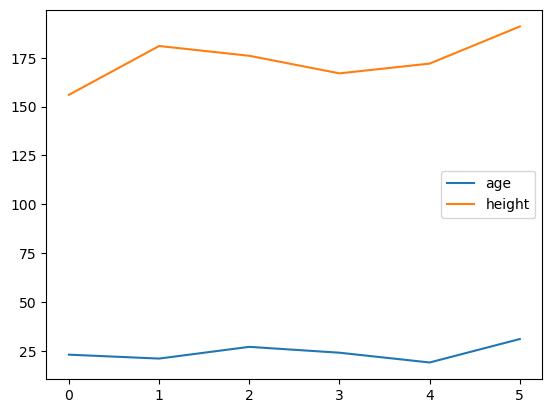

In [18]:
%matplotlib inline
pdf = persons.toPandas()
pdf.plot()

### Attention: Beware of huge DatFrames!
Do not forget hat Apache Spark has been designed and built to handle really huge data sets, which do not need to fit into memory. Spark DataFrames con contain billions of rows and are stored in a distributed way on many nodes in a cluster. Actually the contents do not even need to be physically present at all, as long as the input data is accessible.

But calling the `toPandas()` method will transfer all the records to a single machine (where the Jupyter Notebook runs on) - but maybe this computer does not have enough memory to hold all the data. In this case, you risk that the notebook process will crash with an Out-Of-Memory error (OOM). So you should only use `toPandas()` when you are really sure that the DataFrame contains a limited amount of records.

## Exercise

1. Load in the file "persons.json". This file contains exactly the same data, but is stored as a JSON file instead of a CSV file. 
2. Inspect the schema
3. Show the contents of the file
4. Convert the Spark DataFrame to a Pandas DataFrame

In [23]:
persons = spark.read.json(basedir + "persons.json")
persons

DataFrame[age: bigint, height: bigint, name: string, sex: string]

In [20]:
persons.printSchema()

root
 |-- age: long (nullable = true)
 |-- height: long (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)



In [21]:
persons.show()

+---+------+-------+------+
|age|height|   name|   sex|
+---+------+-------+------+
| 14|   156|  Alice|female|
| 21|   181|    Bob|  male|
| 27|   176|Charlie|  male|
| 24|   167|    Eve|female|
| 19|   172|Frances|female|
| 31|   191| George|  male|
+---+------+-------+------+



In [22]:
persons.toPandas()

,age,height,name,sex
0,14,156,Alice,female
1,21,181,Bob,male
2,27,176,Charlie,male
3,24,167,Eve,female
4,19,172,Frances,female
5,31,191,George,male


## Explicit Schema

Often it is useful to explicitly specify the schema of the data to be read. This approach has multiple advantges: On the one side, Spark does not need to spend additional work for inferring the schema, on the other hand it helps to create robust applications which do not change behaviour when the data schema suddenly changes.

In [24]:
from pyspark.sql.types import *

schema = StructType([
    StructField("age", IntegerType(), nullable=False),
    StructField("height", FloatType()),
    StructField("name", StringType()),
    StructField("sex", StringType())    
])

In [25]:
persons = spark.read \
    .schema(schema) \
    .json(basedir + "persons.json")


In [26]:
persons.show()

+---+------+-------+------+
|age|height|   name|   sex|
+---+------+-------+------+
| 14| 156.0|  Alice|female|
| 21| 181.0|    Bob|  male|
| 27| 176.0|Charlie|  male|
| 24| 167.0|    Eve|female|
| 19| 172.0|Frances|female|
| 31| 191.0| George|  male|
+---+------+-------+------+



In [27]:
persons.printSchema()

root
 |-- age: integer (nullable = true)
 |-- height: float (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)



# 2. Simple Transformations

## Projections

The simplest thing to do is to create a new DataFrame with a subset of the available columns

In [30]:
import pyspark.sql.functions as f

result = persons.select(persons.name, persons['sex'], f.col('height'), persons[0])
result.toPandas()

,name,sex,height,age
0,Alice,female,156.0,14
1,Bob,male,181.0,21
2,Charlie,male,176.0,27
3,Eve,female,167.0,24
4,Frances,female,172.0,19
5,George,male,191.0,31


One noteable concept of Spark is that every transformation will return a new DataFrame. The original DataFrame remains unchanged. This is a deep architectural decision of Spark which simplifies parallel processing under the hood.

## Addressing Columns

Spark supports multiple different ways for *addressing* a columns. We just saw one way, but also the following methods are supported for specifying a column:

* `df.column_name`
* `df['column_name']`
* `col('column_name')`
* `df[idx]`

All these methods return a `Column` object, which is an abstract representative of the data in the column. As we will see soon, transformations can be applied to `Column` in order to derive new values.

### Beware of Lowercase and Uppercase

While PySpark itself is case insenstive concering column names, Python itself is case sensitive. Since the first method for addressing columns by treating them as fields of a Python object *is* Python syntax, this is also case sensitive!

In [31]:
result = persons.select(persons["name"])
result.toPandas()

,name
0,Alice
1,Bob
2,Charlie
3,Eve
4,Frances
5,George


## Exercise

Use all three different methods for addressing a column, and select the following columns:
* name
* age
* height

In [32]:
result = persons.select(persons['name'], persons.age, f.col("height"))
result.limit(3).toPandas()

,name,age,height
0,Alice,14,156.0
1,Bob,21,181.0
2,Charlie,27,176.0


## Transformations

The `select` method actually accepts any *column* object. A *column* object conceptually represents a column in a DataFrame. The column may either refer directly to an existing column of the input DataFrame, or it may represent the result of a calculation or transformation of one or multiple columns of the input DataFrame. For example if we simply want to transform the name into upper case, we can do so by using a function `upper` provided by PySpark.

In [33]:
import pyspark.sql.functions as f

result = persons.select(
  f.upper(persons["name"]),
  persons["height"] * 0.3937008
)

result.toPandas()

,upper(name),(height * 0.3937008)
0,ALICE,61.417325
1,BOB,71.259845
2,CHARLIE,69.291341
3,EVE,65.748034
4,FRANCES,67.716538
5,GEORGE,75.196853


Lets look at a differnt example where we want to create a new DataFrame with the appropriate salutation in front of the name. We achieve this by the following `select` statement:

In [34]:
result = persons.select(f.concat(f.when(persons['sex'] == 'male', "Mr ").otherwise("Mrs "), persons['name']))
result.toPandas()

,"concat(CASE WHEN (sex = male) THEN Mr ELSE Mrs END, name)"
0,Mrs Alice
1,Mr Bob
2,Mr Charlie
3,Mrs Eve
4,Mrs Frances
5,Mr George


### Common Functions

You can find the full list of available functions at [PySpark SQL Module](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/functions.html). Commonly used functions for example are as follows:

* [`concat(*cols)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.concat) - Concatenates multiple input columns together into a single column.
* [`substring(col,start,len)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.substring) - Substring starts at pos and is of length len when str is String type or returns the slice of byte array that starts at pos in byte and is of length len when str is Binary type.
* [`instr(col,substr)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.instr) - Locate the position of the first occurrence of substr column in the given string. Returns null if either of the arguments are null.
* [`locate(col,substr, pos)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.locate) - Locate the position of the first occurrence of substr in a string column, after position pos.
* [`length(col)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.length) - Computes the character length of string data or number of bytes of binary data. 
* [`upper(col)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.upper) - Converts a string column to upper case.
* [`lower(col)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.lower) - Converts a string column to lower case.
* [`coalesce(*cols)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.coalesce) - Returns the first column that is not null.
* [`isnull(col)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.isnull) - An expression that returns true iff the column is null.
* [`isnan(col)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.isnan) - An expression that returns true iff the column is NaN.
* [`hash(cols*)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.hash) - Calculates the hash code of given columns.

Spark also supports conditional expressions, like the SQL `CASE WHEN` construct
* [`when(condition, value)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.when) - Evaluates a list of conditions and returns one of multiple possible result expressions.

There are also some special functions often required
* [`col(str)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.col) - Returns a Column based on the given column name.
* [`lit(val)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.lit) - Creates a Column of literal value.
* [`expr(str)`](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.expr) - Parses the expression string into the column that it represents

### User Defined Functions
Unfortunately you cannot directly use normal Python functions for transforming DataFrame columns. Although PySpark already provides many useful functions, this might not always sufficient. But fortunately you can *convert* a standard Python function into a PySpark function, thereby defining a so called *user defined function* (UDF). Details will be explained in detail in the training.

### Defining new Column Names
The resulting DataFrame again has a schema, but the column names to not look very nice. But by using the `alias` method of a `Column` object, you can immediately rename the newly created column like you are already used to in SQL with `SELECT complex_operation(...) AS nice_name FROM ...`. 

Technically specifying a new name for the resulting column is not required (as we already saw above), if the name is not specified, PySpark will generate a name from the expression. But since this generated name tends to be rather long and contains the logic instead of the intention, it is highly recommended to always explicitly specify the name of the resulting column using `as`.

In [35]:
result = persons.select(
  f.upper(persons["name"]).alias("upper_name"),
  (persons["height"] * 0.3937008).alias("height_inch")
)

result.toPandas()

,upper_name,height_inch
0,ALICE,61.417325
1,BOB,71.259845
2,CHARLIE,69.291341
3,EVE,65.748034
4,FRANCES,67.716538
5,GEORGE,75.196853


## Adding Columns

A special variant of a `select` statement is the `withColumn` method. While the `select` statement requires all resulting columns to be defined in as arguments, the `withColumn` method keeps all existing columns and adds a new one. This operation is quite useful since in many cases new columns are derived from the existing ones, while the old ones still should be contained in the result.

Let us have a look at a simple example, which only adds the salutation as a new column:

In [36]:
result = persons.select(
    persons["*"],
    f.when(persons['sex'] == 'male', "Mr ").otherwise("Mrs ").alias("salutation")
)
result.toPandas()

,age,height,name,sex,salutation
0,14,156.0,Alice,female,Mrs
1,21,181.0,Bob,male,Mr
2,27,176.0,Charlie,male,Mr
3,24,167.0,Eve,female,Mrs
4,19,172.0,Frances,female,Mrs
5,31,191.0,George,male,Mr


In [37]:
result = persons.withColumn("salutation", f.when(persons['sex'] == 'male', "Mr ").otherwise("Mrs "))
result.toPandas()

,age,height,name,sex,salutation
0,14,156.0,Alice,female,Mrs
1,21,181.0,Bob,male,Mr
2,27,176.0,Charlie,male,Mr
3,24,167.0,Eve,female,Mrs
4,19,172.0,Frances,female,Mrs
5,31,191.0,George,male,Mr


As you can see from the example above, `withColumn` always takes two arguments: The first one is the name of the new column (and it has to be a string), and the second argument is the expression containing the logic for calculating the actual contents.

## Removing Columns

PySpark also supports the opposite operation which simply removes some columns from a dataframe. This is useful if you need to remove some sensitive data before saving it to disk:

In [38]:
result = persons.drop("name")
result.toPandas()

,age,height,sex
0,14,156.0,female
1,21,181.0,male
2,27,176.0,male
3,24,167.0,female
4,19,172.0,female
5,31,191.0,male


## Exercise

Using the `persons` DataFrame, perform the following operations:
* Add a new column `status` which should be `child` if the person is younger than 18 and `adult` otherwise
* Replace the column `name` by a new column `hashed_name` containing the hash value of the name
* Drop the column `sex`

In [39]:
result = persons.withColumn("status", f.when(persons["age"] < 21, "child").otherwise("adult")) \
            .withColumn("hashed_name", f.hash(persons["name"])) \
            .drop("sex","name")

result.show()

+---+------+------+-----------+
|age|height|status|hashed_name|
+---+------+------+-----------+
| 14| 156.0| child|-1597477876|
| 21| 181.0| adult|  549595493|
| 27| 176.0| adult|  906014075|
| 24| 167.0| adult|-1915804868|
| 19| 172.0| child| 1222495376|
| 31| 191.0| adult| -454693442|
+---+------+------+-----------+



## Using SQL Expressions

In [40]:
result = persons.select(
    f.expr("CASE WHEN sex = 'male' THEN 'Mr' ELSE 'Mrs' END AS salutation")
)

result.toPandas()

,salutation
0,Mrs
1,Mr
2,Mr
3,Mrs
4,Mrs
5,Mr


# 3. Filtering

*Filtering* denotes the process of keeping only rows which meet a certain filter criteria. PySpark support two different approaches. The first approach specifies the filtering expression as a PySpark expression using columns:

In [41]:
result = persons.filter(persons['age'] > 25)
result.show()

+---+------+-------+----+
|age|height|   name| sex|
+---+------+-------+----+
| 27| 176.0|Charlie|male|
| 31| 191.0| George|male|
+---+------+-------+----+



The second approach simply uses a string containing an SQL expression:

In [42]:
result = persons.filter("age > 20")
result.show()

+---+------+-------+------+
|age|height|   name|   sex|
+---+------+-------+------+
| 21| 181.0|    Bob|  male|
| 27| 176.0|Charlie|  male|
| 24| 167.0|    Eve|female|
| 31| 191.0| George|  male|
+---+------+-------+------+



Of course you can also combine multiple conditions using `&` (and) and `|` (or) with the first approach or by using the SQL keywords `AND` and `OR` in the second approach.

## Exercise
Perform two different filter operations (with two different result sets):
* Select all women with a height of at least 160
* Select all persons which are younger than 20 or older than 30

In [43]:
result = persons.where("sex = 'female' AND height >= 160")
result.show()

+---+------+-------+------+
|age|height|   name|   sex|
+---+------+-------+------+
| 24| 167.0|    Eve|female|
| 19| 172.0|Frances|female|
+---+------+-------+------+



In [44]:
result = persons.where((persons['age'] < 20) | (persons["age"] > 30))
result.show()

+---+------+-------+------+
|age|height|   name|   sex|
+---+------+-------+------+
| 14| 156.0|  Alice|female|
| 19| 172.0|Frances|female|
| 31| 191.0| George|  male|
+---+------+-------+------+



# 4. Simple Aggregations

PySpark provides some very basic aggregate functions, like `count()`

In [45]:
persons.count()

6

Of course, you often want to use different aggregate functions and not only counting records. PySpark well supports common aggregate functions like `min`,  `max`, `sum` etc. These can be used inside a `select` function, similar to SQL:

In [46]:
result = persons.select(
        f.max(persons['age']).alias("max_age"), 
        f.avg(persons['height']).alias("avg_height")
    )
result.toPandas()

,max_age,avg_height
0,31,173.833333


# 5. Grouping & Aggregation

An important class of operation is grouping and aggregation, which is equivalnt to an SQL `SELECT aggregation GROUP BY grouping` statement. In PySpark, grouping and aggregation is always performed by first creating groups using `groupBy` immediately followed by aggregation expressions inside an `agg` method. (Actually there are also some predefined aggregations which can be used instead of `agg`, but they do not offer the flexiviliby which is required most of the time).

Note that in the `agg` method you only need to specify the aggregation expression, the grouping columns are added automatically by PySpark to the resulting DataFrame.

In [47]:
result = persons.groupBy(persons['sex']).agg(
    f.avg(persons['age']).alias('avg_age'),
    f.min(persons['height']).alias('min_height'),
    f.max(persons['height']).alias('max_height'))
result.toPandas()

,sex,avg_age,min_height,max_height
0,female,19.000000,156.0,172.0
1,male,26.333333,176.0,191.0


## Aggregation Functions

PySpark supports many aggregation functions, they can be found in the documentation at [PySpark Function Documentation](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/functions.html#aggregate-functions). Aggregation functions are marked as such in the documentation. Among common aggregation functions, there are for example:

* count
* sum
* avg
* corr
* first
* last

## Exercise

Using the `persons` DataFrame, calculate the average height and the number of records per sex.

# 6. Sorting

PySpark also supports sorting data with the `orderBy` method. For example we can sort all persons by their name as follows:

In [48]:
result = persons.orderBy(persons['height'])
result.toPandas()

,age,height,name,sex
0,14,156.0,Alice,female
1,24,167.0,Eve,female
2,19,172.0,Frances,female
3,27,176.0,Charlie,male
4,21,181.0,Bob,male
5,31,191.0,George,male


If nothing else is specified, PySpark will sort the records in increasing order of the sort columns. If you require descending order, this can be specified by manipulating the sort column with the `desc()` method as follows:

In [49]:
result = persons.orderBy(persons['height'].desc())
result.toPandas()

,age,height,name,sex
0,31,191.0,George,male
1,21,181.0,Bob,male
2,27,176.0,Charlie,male
3,19,172.0,Frances,female
4,24,167.0,Eve,female
5,14,156.0,Alice,female


## Exercise

As an exercise we want to sort all persons first by their sex and then by their descening age. Sorting by multiple columns can easily be achieved by specifying multiple columns as arguments in the `orderBy` method.

In [50]:
result = persons.orderBy(persons['sex'], persons['age'].desc())
result.toPandas()

,age,height,name,sex
0,24,167.0,Eve,female
1,19,172.0,Frances,female
2,14,156.0,Alice,female
3,31,191.0,George,male
4,27,176.0,Charlie,male
5,21,181.0,Bob,male


# 7. Joining Data

Every relation algebra also contains join operations which lets you combine multiple tables by a matching criterion. PySpark also supports joins of multiple DataFrames. In order to shed some light on that, we need a second DataFrame in addition to the `persons` DataFrame. Therefore we load some address data as follows:

In [51]:
addresses = spark.read.json(basedir + "addresses.json")
addresses.toPandas()

,city,name
0,Hamburg,Alice
1,Frankfurt,Bob
2,Berlin,Henry


Now that we have the `addresses` DataFrame, we want to combine it with the `persons` DataFrame such that the city of every person is added as a new column. This is achieved by the `join` method which essentially takes two parameters: The first parameter specifies the second DataFrame to join with, and the second parameter specifies the join condition. In this case we want to join all records, where the `name` column matches.

In [52]:
result = persons.join(addresses,persons["name"] == addresses["name"])
result.toPandas()

,age,height,name,sex,city,name
0,14,156.0,Alice,female,Hamburg,Alice
1,21,181.0,Bob,male,Frankfurt,Bob


Let me make some relevant remarks:
* The resulting DataFrame now contains two `name` columns - one comes from the `persons` DataFrame, the other from the `addresses` DataFrame. Since the join condition could have used some more complex expression, this behaviour is only logical since PySpark cannot assume that all joins simply use directly some column value. For example we could also have transformed the column on the fly by converting the name to upper case directly inside the join condition.
* The result contains only persons where an address was found, although the original `persons` DataFrame contained more persons.
* There are no records of addresses without any person, although the `addresses` DataFrame contains information about some persons not available in the `persons` DataFrame.

So let us first address the first observation. We can easily get rid of the copied `name` column by either performing an explicit select of the desired columns, or by dropping the duplicate columns. Since PySpark records the lineage of every column, the duplicate `name` columns can be addressed by their original DataFrame even after the join operation:

In [53]:
result = persons.join(addresses, persons['name'] == addresses['name']) \
    .select(
        f.col("*"),
        f.coalesce(addresses['name'], persons['name']).alias('name')
    ) \
    .drop(addresses['name'], persons['name'])

result.show()

+---+------+------+---------+-----+
|age|height|   sex|     city| name|
+---+------+------+---------+-----+
| 14| 156.0|female|  Hamburg|Alice|
| 21| 181.0|  male|Frankfurt|  Bob|
+---+------+------+---------+-----+



Now let us explain the last two observations. These are due to the used join type, which was a so called *inner* join. In this case, only records with information from both DataFrames are included in the result.

In addition to the *inner* join, PySpark also supports some additional joins:
* *outer join* will contain records for all elements from both DataFrames. If either the left or right DataFrames doesn't contain any information, the result will contain `None` values (= `NULL` values) for the corresponding columns.
* In a *right join*, the second DataFrame (the right DataFrame) as specified as an argument is the leading element. The result will contain records for every record in that DataFrame.
* In a *left join*, the first DataFrame (the left DataFrame) as specified as the object iteself is the leading element. The result will contain records for every record in that DataFrame.

In [54]:
result = persons.join(addresses, persons["name"] == addresses["name"], how="outer")
result.toPandas()

,age,height,name,sex,city,name
0,14.0,156.0,Alice,female,Hamburg,Alice
1,21.0,181.0,Bob,male,Frankfurt,Bob
2,27.0,176.0,Charlie,male,None,None
3,24.0,167.0,Eve,female,None,None
4,19.0,172.0,Frances,female,None,None
5,31.0,191.0,George,male,None,None
6,NaN,NaN,None,None,Berlin,Henry


In [55]:
result = persons.join(addresses, persons["name"] == addresses["name"], how="right")
result.toPandas()

,age,height,name,sex,city,name
0,14.0,156.0,Alice,female,Hamburg,Alice
1,21.0,181.0,Bob,male,Frankfurt,Bob
2,NaN,NaN,None,None,Berlin,Henry


In [56]:
result = persons.join(addresses, persons["name"] == addresses["name"], how="left")
result.toPandas()

,age,height,name,sex,city,name
0,14,156.0,Alice,female,Hamburg,Alice
1,21,181.0,Bob,male,Frankfurt,Bob
2,27,176.0,Charlie,male,None,None
3,24,167.0,Eve,female,None,None
4,19,172.0,Frances,female,None,None
5,31,191.0,George,male,None,None


In addition to the capability to join on expression, Spark also supports joining via column names. In this case, both data frames need to contain the corresponding column(s). Of course, and you cannot apply any column transformations during the join itself. But the result will contain only a single column containing values from both sides, as can be seen with an `outer` join.

In [57]:
result = persons.join(addresses, ["name"], how="outer")
result.toPandas()

,name,age,height,sex,city
0,Alice,14.0,156.0,female,Hamburg
1,Bob,21.0,181.0,male,Frankfurt
2,Charlie,27.0,176.0,male,None
3,Eve,24.0,167.0,female,None
4,Frances,19.0,172.0,female,None
5,George,31.0,191.0,male,None
6,Henry,NaN,NaN,None,Berlin


## Exercise

As an exercise, we use another DataFrame loaded from a file called `lastnames.json`, which can be joined to the `persons` DataFrame again:

In [58]:
lastnames = spark.read.json(basedir + "lastnames.json")
lastnames.toPandas()

,last_name,name
0,Liddell,Alice
1,Baumeister,Bob
2,Gates,Bob


Now join the `lastnames` DataFrame to the `persons` DataFrame whenever the `name` column of both DataFrames matches. Note what happens due to the fact that we have two last names for `Bob`

In [59]:
result = persons.join(lastnames, persons["name"] == lastnames["name"])
result.show()

+---+------+-----+------+----------+-----+
|age|height| name|   sex| last_name| name|
+---+------+-----+------+----------+-----+
| 14| 156.0|Alice|female|   Liddell|Alice|
| 21| 181.0|  Bob|  male|     Gates|  Bob|
| 21| 181.0|  Bob|  male|Baumeister|  Bob|
+---+------+-----+------+----------+-----+



# 8 Using SQL

PySpark also directly supports SQL. In order to work with SQL, you only need to register a PySpark DataFrame as a *temporary view*, which provides a name to a DataFrame which can be referenced in SQL queries later.

In [61]:
import pyspark.sql.functions as f

persons = spark.read.json("s3://dimajix-training/data/persons.json")
addresses = spark.read.json("s3://dimajix-training/data/addresses.json")

In [62]:
persons.createOrReplaceTempView("persons")

result = spark.sql("SELECT * FROM persons")
result.toPandas()

,age,height,name,sex
0,14,156,Alice,female
1,21,181,Bob,male
2,27,176,Charlie,male
3,24,167,Eve,female
4,19,172,Frances,female
5,31,191,George,male


## Exercise

Perform the following tasks, in order to join `persons` with `addresses`in SQL:

* Register `addresses` DataFrame as `addresses`
* Join `persons` with `addresses`
* Only select persons which are 21 years or older

In [63]:
addresses.createOrReplaceTempView("addresses")

result = spark.sql("""
    SELECT
        *
    FROM persons
    LEFT JOIN addresses ON persons.name = addresses.name
    WHERE persons.age >= 21
""")
result.toPandas()

,age,height,name,sex,city,name
0,21,181,Bob,male,Frankfurt,Bob
1,27,176,Charlie,male,None,None
2,24,167,Eve,female,None,None
3,31,191,George,male,None,None


# 9. User Defined Functions

Sometimes the built in functions do not suffice or you want to call an existing function of a Python library. Using User Defined Functions (UDF) it is possible to wrap an existing function into a Spark DataFrame function. A very simple (but inefficient) way is as follows:

In [64]:
import html

html.escape("Alice & Bob")

'Alice &amp; Bob'

In [65]:
df = spark.createDataFrame([
        ("Alice & Bob",),
        ("Thelma & Louise",)
    ], ["name"])

df.show()

+---------------+
|           name|
+---------------+
|    Alice & Bob|
|Thelma & Louise|
+---------------+



In [66]:
from pyspark.sql.types import *

html_encode = f.udf(html.escape, StringType())

result = df.select(html_encode(df['name']).alias("html_name"))
result.toPandas()

,html_name
0,Alice &amp; Bob
1,Thelma &amp; Louise


# 10. Writing Data

In [61]:
persons.write.mode('overwrite').csv('names_ages')

# What is Missing

We just introduced the most important and common operations in PySpark. The workshop will add some more details to many of these operations and adds the following topics:
* Vectorized Pandas User Defined Functions
* PySpark integration into Hadoop platform
* Working with Hive
* Window Functions
* Runtime Architecture
* File Formats
* ...